# FM Demodulator

## Required Libraries

The project use the ``scikit-dsp-comm`` library for many of our dsp functions.

https://scikit-dsp-comm.readthedocs.io/en/latest/

One can install ``scikit-dsp-comm`` using pip.  
```
pip3 install scikit-dsp-comm==1.3
```

They recently decided to move the features related to the rtl sdr to their own separate libraries, which is why we are using an old version. The newer versions are ``pyrtlsdr`` and ``pyaudio_helper`` which requires ``portaudio`` to be installed. **It is not necessary to install these libraries when using version 1.3 of ``scikit-dsp-comm``.** These are only listed for your information and potential future versions of this project.  
```
! pip install pyrtlsdr
! brew install portaudio
! pip install pyaudio_helper
! pip install -e rtlsdr_helper
```

In [1]:
import sk_dsp_comm.rtlsdr_helper as sdr

import time

## Load Pre-sampled Data
``samples.npy`` is one second worth of RF data sampled in the San Diego area using an RTL-SDR. The ``sample_rate = 2.4e6`` resulting in 2.4M samples. The ``center_freq = 94.1e6``, i.e., tuning the radio to 94.1MHz. The ``gain`` was set to 40.2. 

In [2]:
"""
Load presampled data from from samples.npy  
"""
import numpy as np
samples = np.load('samples.npy')

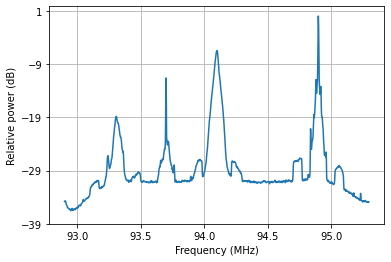

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
# use matplotlib to estimate and plot the PSD
sample_rate = 2.4e6 
center_freq = 94.1e6
plt.psd(samples, NFFT=1024, Fs=sample_rate/1e6, Fc=center_freq/1e6)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative power (dB)')

plt.show()

As you can see in the power spectral density plot, there is a strong signal at 94.1MHz. This is KMYI radio channel local to the San Diego area.

## Demodulating the FM signal

The next step is demodulating the FM signal centered at 94.1 MHz and play it as audio. That is, we wish to listen to the audio that was captured and stored in `samples`.

The FM demodulator source code is taken directly from the ``mono_FM`` implementation from the ``rtlsdr_helper`` in the ``scikit-dsp-comm`` library. That code is available at: https://github.com/scikit-dsp-comm/sdr_helper/blob/master/sk_dsp_comm/sdr_helper/sdr_helper.py. It includes the function ``mono_fm`` and ``discrim``. ``mono_fm`` uses a ``downsample`` function whose source was taken from: https://github.com/mwickert/scikit-dsp-comm/blob/master/sk_dsp_comm/sigsys.py#L2673. We have rewritten all of these functions below for your convenience with renamed functions (adding ``_impl``).

In [4]:
import scipy.signal as signal
import numpy as np
import sk_dsp_comm.sigsys as ss

def downsample_impl(x, M, p=0):  
    if not isinstance(M, int):
        raise TypeError("M must be an int")
    x = x[0:int(np.floor(len(x)/M))*M]
    x = x.reshape((int(np.floor(len(x)/M)),M))
    y = x[:,p]
    return y

def discrim_impl(x):
    """
    function disdata = discrim(x)
    where x is an angle modulated signal in complex baseband form.
    
    Mark Wickert
    """
    X=np.real(x)        # X is the real part of the received signal
    Y=np.imag(x)        # Y is the imaginary part of the received signal
    b=np.array([1, -1]) # filter coefficients for discrete derivative
    derY=signal.lfilter(b,1,Y)  # derivative of Y, 
    derX=signal.lfilter(b,1,X)  #    "          X,
    disdata=(X*derY-Y*derX)/(X**2+Y**2)
    return disdata

def mono_FM_impl(x,fs=2.4e6,file_name='test.wav'):
    """
    Decimate complex baseband input by 10
    Design 1st decimation lowpass filter (f_c = 200 KHz)
    """
    b = signal.firwin(64,2*200e3/float(fs))
    # Filter and decimate (should be polyphase)
    y = signal.lfilter(b,1,x)
    z = downsample_impl(y,10)
    # Apply complex baseband discriminator
    z_bb = discrim_impl(z)
    # Design 2nd decimation lowpass filter (fc = 12 KHz)
    bb = signal.firwin(64,2*12e3/(float(fs)/10))
    # Filter and decimate
    zz_bb = signal.lfilter(bb,1,z_bb)
    # Decimate by 5
    z_out = downsample_impl(zz_bb,5)
    # Save to wave file
    ss.to_wav(file_name, 48000, z_out/2)
    print('Done!')
    return z_bb, z_out

In [5]:
import time
from IPython.display import Audio

tic = time.time()
z_bb, z_out = mono_FM_impl(samples, fs=2.4e6, file_name='SW1.wav')
toc = time.time()
print("Proceesing time: {} seconds".format(toc - tic))

Audio('SW1.wav')

Done!
Proceesing time: 0.1403179168701172 seconds


## Downsample function

``downsample`` takes a list of elements ``x`` and a downsample factor ``M``. It keeps every *Mth* element from ``x``. 

```python
    def downsample_impl(x, M, p=0):  
    if not isinstance(M, int):
        raise TypeError("M must be an int")
    x = x[0:int(np.floor(len(x)/M))*M]
    x = x.reshape((int(np.floor(len(x)/M)),M))
    y = x[:,p]
    return y
```

The hardware implementation is much more straightforward and requires only passing every *Mth* element from the input to the output.

## discrim function

``discrim`` takes a complex signal, calculates the derivative of its phase which provides its frequency. ``discrim`` first calculates the derivative of Y and X, which is simply the change between two consecutive values. It then uses this to calculate the derivative of the phase via the equation ``(X*derY-Y*derX)/(X**2+Y**2)``.

```python
    def discrim_impl(x):
        """
        function disdata = discrim(x)
        where x is an angle modulated signal in complex baseband form.
    
        Mark Wickert
        """
        X=np.real(x)        # X is the real part of the received signal
        Y=np.imag(x)        # Y is the imaginary part of the received signal
        b=np.array([1, -1]) # filter coefficients for discrete derivative
        derY=signal.lfilter(b,1,Y)  # derivative of Y, 
        derX=signal.lfilter(b,1,X)  #    "          X,
        disdata=(X*derY-Y*derX)/(X**2+Y**2)
        return disdata
```

## lfilter function

The ``lfilter`` function implementation is available at: https://github.com/scipy/scipy/blob/v1.5.4/scipy/signal/signaltools.py#L1719-L1909

This filter function is implemented as a direct II transposed structure.

    This means that the filter implements:
       a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]
                             - a[1]*y[n-1] - ... - a[N]*y[n-N]
                             
Since in all of our functions calls, we call this function as ``lfilter(b,1,x)``, the following ``linear_function`` is the simplified implementation of `lfilter` that is sufficient for *mono_FM*

## Final Python implementation
The FM demodulator and all of its functions is shown below.

In [6]:
import scipy.signal as signal
import numpy as np
import sk_dsp_comm.sigsys as ss

def linear_filter(b, x):
    y = np.zeros_like(x)
    buff = np.zeros(b.shape, dtype=type(x[0]))
    b_len = len(buff)
    for i in range(len(y)):
        for j in range(b_len-1):
            buff[b_len-1-j] = buff[b_len-2-j]
        buff[0] = x[i]
        
        temp = 0
        for j in range(b_len):
            temp += buff[j]*b[j]
        y[i] = temp
    return y

def downsample_impl(x, M, p=0):  
    if not isinstance(M, int):
        raise TypeError("M must be an int")
    x = x[0:int(np.floor(len(x)/M))*M]
    x = x.reshape((int(np.floor(len(x)/M)),M))
    y = x[:,p]
    return y

def discrim_impl(x):
    """
    function disdata = discrim(x)
    where x is an angle modulated signal in complex baseband form.
    
    Mark Wickert
    """
    X=np.real(x)        # X is the real part of the received signal
    Y=np.imag(x)        # Y is the imaginary part of the received signal
    b=np.array([1, -1]) # filter coefficients for discrete derivative
    derY=linear_filter(b,Y)  # derivative of Y, 
    derX=linear_filter(b,X)  #    "          X,
    disdata=(X*derY-Y*derX)/(X**2+Y**2)
    return disdata

def mono_FM_impl(x,fs=2.4e6,file_name='test.wav'):
    """
    Decimate complex baseband input by 10
    Design 1st decimation lowpass filter (f_c = 200 KHz)
    """
    b = signal.firwin(64,2*200e3/float(fs))
    # Filter and decimate (should be polyphase)
    y = linear_filter(b,x)
    z = downsample_impl(y,10)
    # Apply complex baseband discriminator
    z_bb = discrim_impl(z)
    # Design 2nd decimation lowpass filter (fc = 12 KHz)
    bb = signal.firwin(64,2*12e3/(float(fs)/10))
    # Filter and decimate
    zz_bb = linear_filter(bb,z_bb)
    # Decimate by 5
    z_out = downsample_impl(zz_bb,5)
    # Save to wave file
    # ss.to_wav(file_name, 48000, z_out/2)
    print('Done!')
    return z_bb, z_out

In [7]:
import time

tic = time.time()
z_bb, z_out = mono_FM_impl(samples, fs=2.4e6)
toc = time.time()
print("Proceesing time: {} seconds".format(toc - tic))
Audio(z_out, rate=48000)

Done!
Proceesing time: 75.09053206443787 seconds


## Function Specifications

In this section, we take a look at our function calls and their input/output variable types.

### Input data to ``mono_fm``

In [8]:
print(samples.shape, type(samples[0]))
print(type(samples.real[0]))
print(type(samples.imag[0]))

(2400000,) <class 'numpy.complex128'>
<class 'numpy.float64'>
<class 'numpy.float64'>


Our samples are ``complex128`` (64-bit float real, 64-bit float imaginary). 

### Coeffiicents corresponding to the first ``linear_filter``

In [9]:
fs = 2.4e6
b = signal.firwin(64,2*200e3/float(fs))
print(b.shape, type(b[0]))

(64,) <class 'numpy.float64'>


**b** is an array of float64 with 64 elements. 

### First ``linear_filter`` output

In [10]:
y = linear_filter(b,samples[0:128])
print(y.shape, type(y[0]))

(128,) <class 'numpy.complex128'>


The output is the same size as input with complex variables.

### First ``downsample`` output

In [11]:
z = downsample_impl(y,10)
print(z.shape, type(z[0]))

(12,) <class 'numpy.complex128'>


with a downsampling rate of 10, output's size is 1/10 of input with same data type.

### ``discrim`` output

In [12]:
z_bb = discrim_impl(z)
print(z_bb.shape, type(z_bb[0]))

(12,) <class 'numpy.float64'>


*discrim* function accepts complex input and produces float outputs with the same length.

### Second ``linear_filter`` coefficients

In [13]:
bb = signal.firwin(64,2*12e3/(float(fs)/10))
print(bb.shape, type(bb[0]))

(64,) <class 'numpy.float64'>


``bb`` is an array of ``float64`` with 64 elements.

### Second ``linear_filter`` output

In [14]:
zz_bb = linear_filter(bb,z_bb)
print(zz_bb.shape, type(zz_bb[0]))

(12,) <class 'numpy.float64'>


The output is the same size and type as the input.

### Second ``downsample`` output

In [15]:
z_out = downsample_impl(zz_bb,5)
print(z_out.shape, type(z_out[0]))

(2,) <class 'numpy.float64'>


with a downsampling rate of 5, output's size is 1/5 of input with same data type. This is also the final output of the ``mono_fm`` function.